In [2]:
from typing import cast, Dict, List, Union

import torch
from torch import Tensor
from torch import nn
from random import shuffle
import cv2
import torchvision

import os
import time
from torch import optim
import torch
from torch import nn
from torch import optim
from torch.cuda import amp
from torch.optim import lr_scheduler
from torch.optim.swa_utils import AveragedModel
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, models, transforms

import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.utils.data as td
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from matplotlib import image
from matplotlib import pyplot


In [3]:
# os.makedirs('./COVID19-DATASET/train/covid')
# os.makedirs('./COVID19-DATASET/train/normal')
# os.makedirs('./COVID19-DATASET/train/pneumonia')
# os.makedirs('./COVID19-DATASET/train/lung_opacity')

COVID_PATH = "../input/dataset1/data/covid/"
NORMAL_PATH = "../input/dataset1/data/normal/"
PNEUMONIA_PATH = "../input/dataset1/data/pneumonia/"
PNEUMONIA_PATH = "../input/dataset1/data/lung_opacity/"



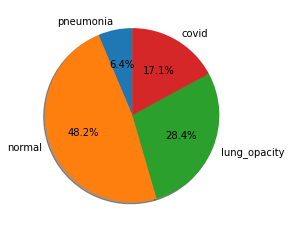

In [4]:
DATA_PATH = '../input/dataset1/data'
class_names = os.listdir(DATA_PATH)
image_count = {}
for i in class_names:
    image_count[i] = len(os.listdir(os.path.join(DATA_PATH,i)))

#Plotting Distribution of Each Classes
fig1, ax1 = plt.subplots()
ax1.pie(image_count.values(),
        labels = image_count.keys(),
        shadow=True,
        autopct = '%1.1f%%',
        startangle=90)
plt.show()

In [5]:
def show_image(img):
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.imshow(img)
    ax.set_axis_off()
    plt.tight_layout()
    plt.show()

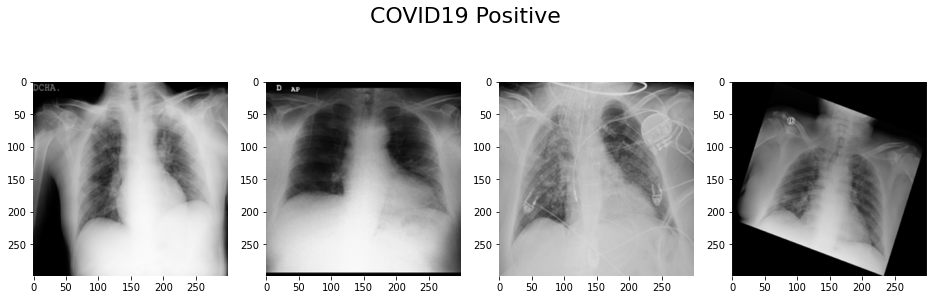

In [6]:
fig = plt.figure(figsize=(16,5))
fig.suptitle("COVID19 Positive", size=22)
img_paths = os.listdir(COVID_PATH)
shuffle(img_paths)

for i,image in enumerate(img_paths[:4]):
    img = cv2.imread(os.path.join(COVID_PATH, image))
    plt.subplot(1,4, i+1, frameon=False)
    plt.imshow(img)
    # print(os.path.join(COVID_PATH, image))
fig.show()

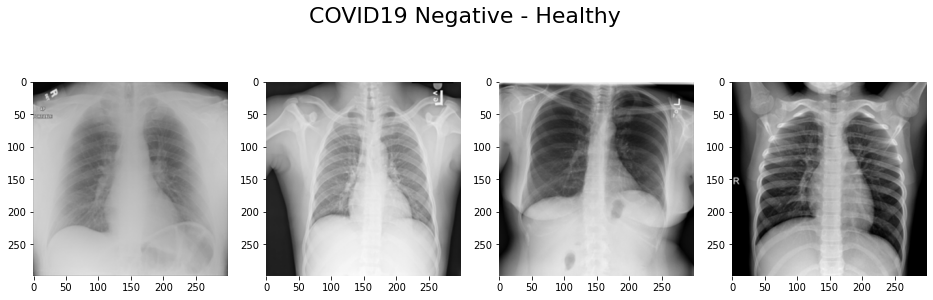

In [7]:
fig = plt.figure(figsize=(16,5))
fig.suptitle("COVID19 Negative - Healthy", size=22)
img_paths = os.listdir(NORMAL_PATH)
shuffle(img_paths)

for i,image in enumerate(img_paths[:4]):
    img = cv2.imread(os.path.join(NORMAL_PATH, image))
    plt.subplot(1,4, i+1, frameon=False)
    plt.imshow(img)
fig.show()

In [8]:
from numpy.core.fromnumeric import shape
def load_data(path,batch_size,input_size):
    
    normalize = transforms.Compose([
        transforms.Resize((227,227)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        ]) 
    transform_dict = {"src":  normalize}  
    # train_path=path+"/train"
    # test_path=path+"/test"
    data = datasets.ImageFolder(root=path,transform=transform_dict["src"])
    # transform_dict1 = {"test":  normalize} 
    # test1 = datasets.ImageFolder(root=path,transform=transform_dict["test"])
    # transform_dict = {"test":  normalize}
    # test= datasets.ImageFolder(root=path,transform=transform_dict["test"])
    # train_size = int((1- (test_split + val_split)) * len(data))
    # test_size = int((1 - (val_split)) * len(data)) - train_size
    # val_size = len(data) - train_size - test_size
    train_size=int(0.75*len(data))
    test_size=int(len(data)-train_size)
    train, test = td.random_split(data,[train_size,test_size])

    data_loader_train = td.DataLoader(train,batch_size=batch_size,shuffle=True,drop_last=False,num_workers=0)
    data_loader_test = td.DataLoader(test,batch_size=batch_size,shuffle=True,drop_last=False,num_workers=0)
    # data_loader_val = td.DataLoader(val,batch_size=batch_size,shuffle=True,drop_last=False,num_workers=0)
    return data_loader_train, data_loader_test

In [9]:
data_loader_train,data_loader_test=load_data(r"../input/dataset1/data",32,64)

In [11]:
# model = vgg11();
import torch.optim as optim
from torchvision.models import resnet50
model=resnet50()
resnet50(pretrained=False) 
# model = torch.hub.load('pytorch/vision:v0.10.0', 'vgg11', pretrained=True)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'vgg11_bn', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'vgg13', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'vgg13_bn', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'vgg16', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'vgg16_bn', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'vgg19', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'vgg19_bn', pretrained=True)

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: {}".format(device))
model.to(device)
Accuracies = []
num_epochs = 20
total_steps = len(data_loader_train)
t1 = time.time()
for epoch in range(num_epochs):
    for i, data in enumerate(data_loader_train):
        images, labels = data[0].to(device), data[1].to(device)
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        # Backprop and optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Train accuracy
        total = labels.size(0)
        _,predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        
        if (i + 1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                .format(epoch + 1, num_epochs, i + 1, total_steps, loss.item(),
                    (correct / total) * 100))
            Accuracies.append((correct / total) * 100)
print("######## Training Finished in {} seconds ###########".format(time.time()-t1))

Device: cuda:0
Epoch [1/20], Step [100/497], Loss: 0.9099, Accuracy: 59.38%
Epoch [1/20], Step [200/497], Loss: 0.5241, Accuracy: 87.50%
Epoch [1/20], Step [300/497], Loss: 0.7311, Accuracy: 71.88%
Epoch [1/20], Step [400/497], Loss: 0.5169, Accuracy: 71.88%
Epoch [2/20], Step [100/497], Loss: 0.9212, Accuracy: 78.12%
Epoch [2/20], Step [200/497], Loss: 0.4592, Accuracy: 87.50%
Epoch [2/20], Step [300/497], Loss: 0.4202, Accuracy: 81.25%
Epoch [2/20], Step [400/497], Loss: 0.4721, Accuracy: 81.25%
Epoch [3/20], Step [100/497], Loss: 0.5212, Accuracy: 87.50%
Epoch [3/20], Step [200/497], Loss: 0.5890, Accuracy: 81.25%
Epoch [3/20], Step [300/497], Loss: 0.5214, Accuracy: 81.25%
Epoch [3/20], Step [400/497], Loss: 0.3718, Accuracy: 90.62%
Epoch [4/20], Step [100/497], Loss: 0.2395, Accuracy: 90.62%
Epoch [4/20], Step [200/497], Loss: 0.5492, Accuracy: 68.75%
Epoch [4/20], Step [300/497], Loss: 0.5146, Accuracy: 78.12%
Epoch [4/20], Step [400/497], Loss: 0.4959, Accuracy: 84.38%
Epoch [5/

Test Accuracy of the model on the 5292 test images: 90.94860166288737 %


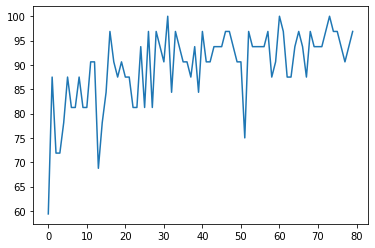

In [13]:
model.eval() 
perds = []
target = []
with torch.no_grad(): 
    correct = 0
    total = 0
    for data in data_loader_test:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        perds.extend(predicted)
        target.extend(labels)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print('Test Accuracy of the model on the {} test images: {} %'
        .format(total, (correct / total) * 100))
    
plt.plot(Accuracies)

In [14]:
!pip install torchmetrics

In [16]:
from torchmetrics.functional import precision_recall
from torchmetrics import F1Score
from torchmetrics import ConfusionMatrix
perds1 = torch.stack(perds)
target1 = torch.stack(target)
f1 = F1Score(num_classes=4).to(device)
print(f1(perds1, target1))
print(precision_recall(perds1, target1, average='macro', num_classes=4))
confmat = ConfusionMatrix(num_classes=4).to(device)
confmat(perds1, target1)

tensor(0.9095, device='cuda:0')
(tensor(0.9090, device='cuda:0'), tensor(0.9236, device='cuda:0'))


tensor([[ 837,   18,   50,   12],
        [  14, 1329,  141,    2],
        [  16,  190, 2314,   29],
        [   1,    0,    6,  333]], device='cuda:0')